### _Keras-Tensoflow implementtation of video classification using ConvLSTM_
Author : @leopauly | cnlp@leeds.ac.uk

In [1]:
##Imports
import numpy as np
import cv2
import os
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten, MaxPooling2D, Input
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
import numpy as np
import pylab as plt
from read_activations import *

##Custom scripts
import lscript as lsp
import dataset as dset

Using TensorFlow backend.


In [2]:
## Defining variables
time_step=50 # Number of frames to be skipped
imagefolderpath= ('/nobackup/leopauly/video_data/task1/') # Folder pathe where the video sequences are stored
print(os.path.isdir('/nobackup/leopauly/video_data/task1/')) # Checking if directory of video dataset exists
batch_size=2
LOG_DIR='./logdir'
custom_global_step=0
hidden_num = 24 # Number of neurons in hidden layer of LSTM
nb_classes=2
lr_rate=.0005
batch_size = 2
nb_seq_train=2
no_of_batches = int(nb_seq_train / batch_size)
epoch = 5
height=300
width=600
channel=1

True


#### Loading and displaying data

(2, 50, 300, 600)


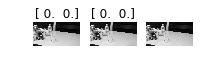

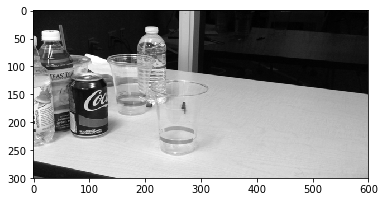

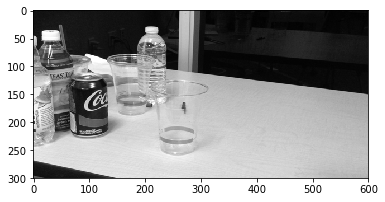

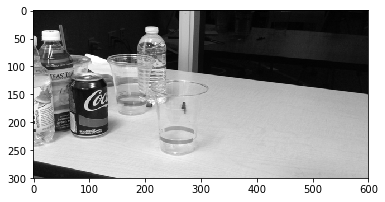

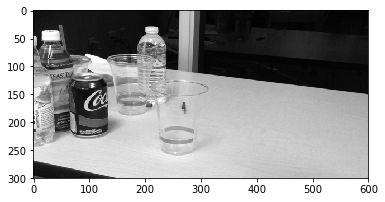

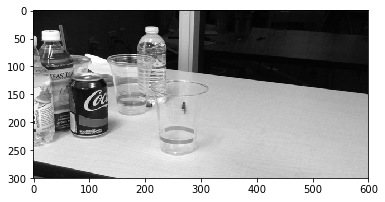

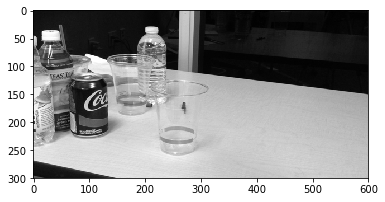

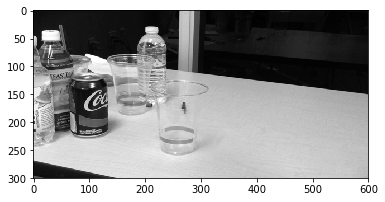

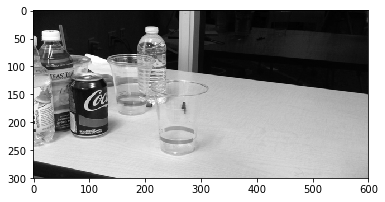

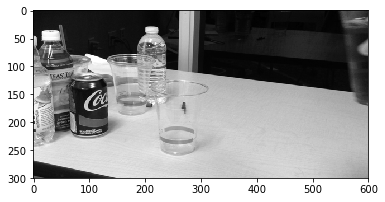

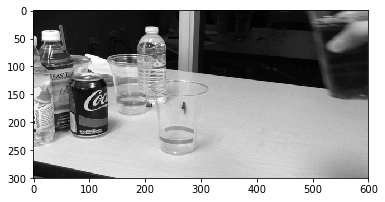

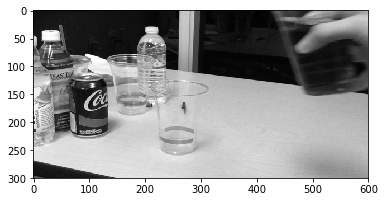

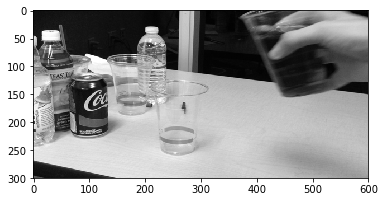

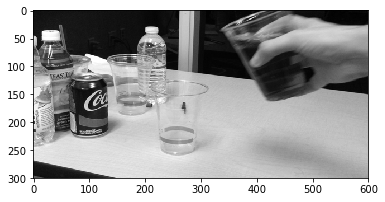

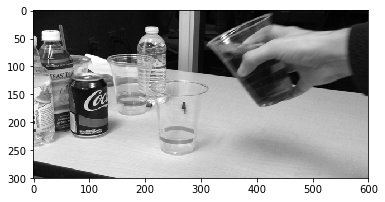

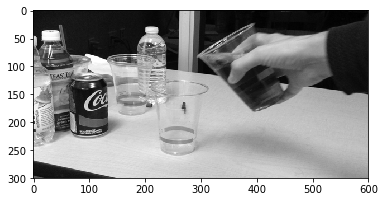

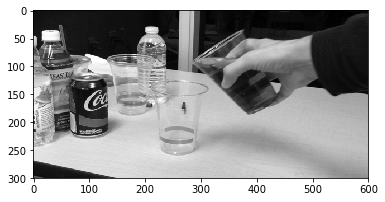

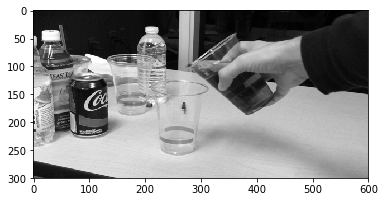

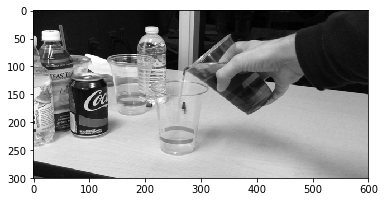

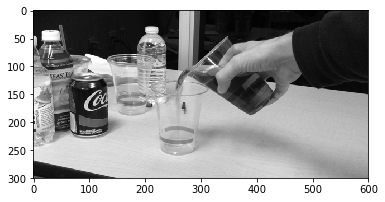

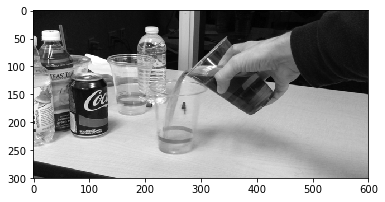

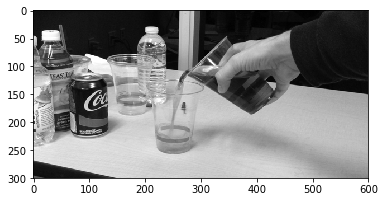

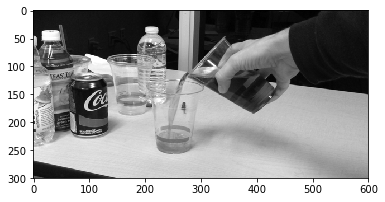

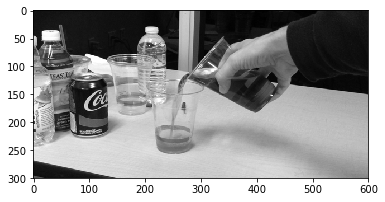

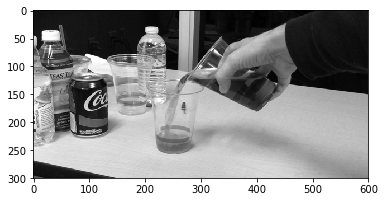

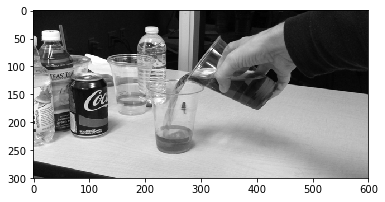

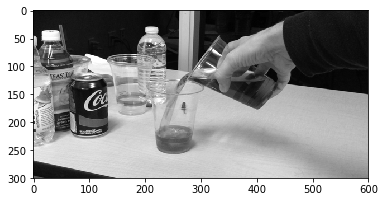

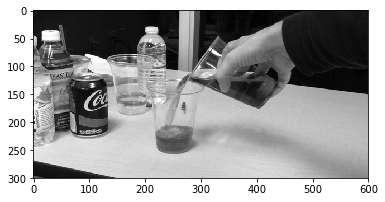

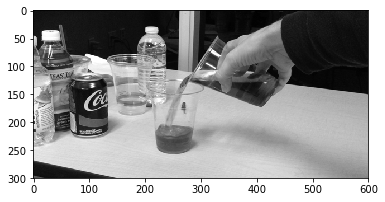

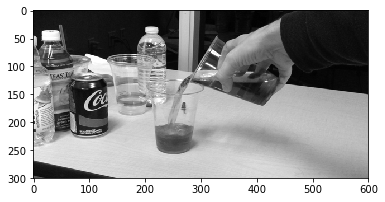

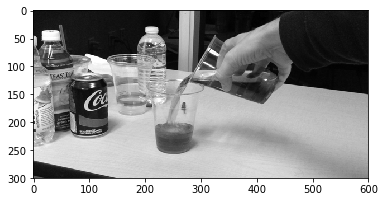

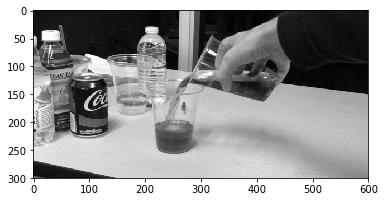

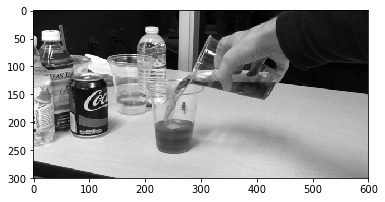

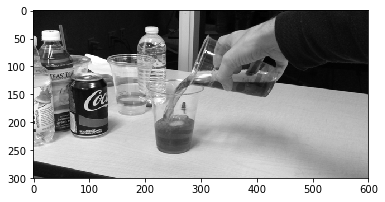

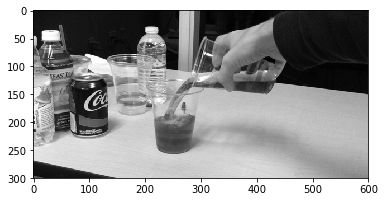

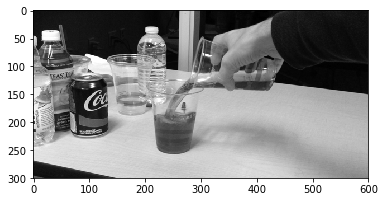

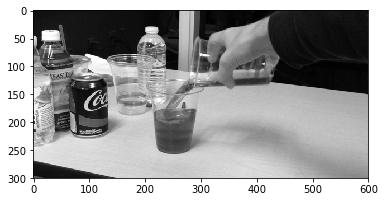

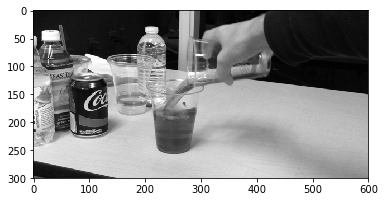

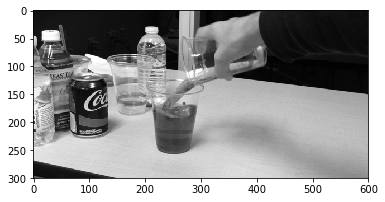

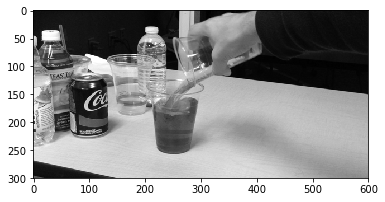

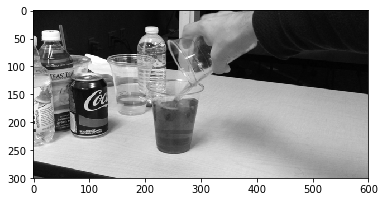

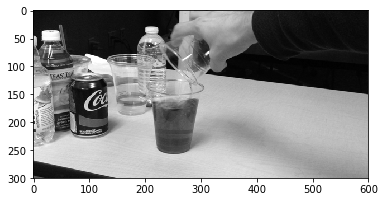

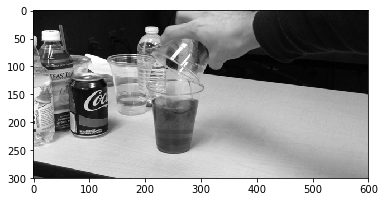

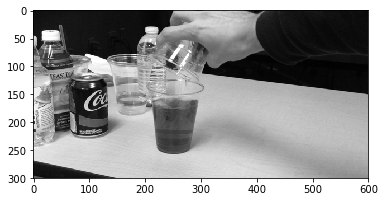

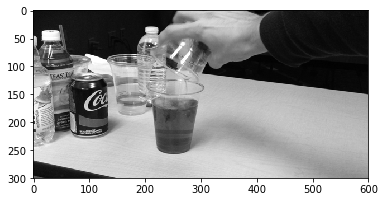

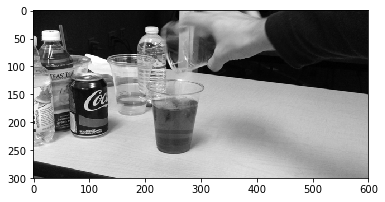

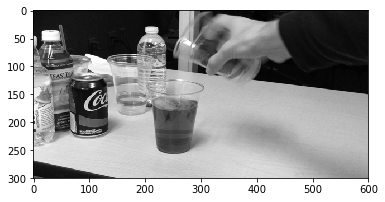

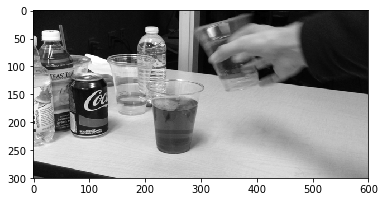

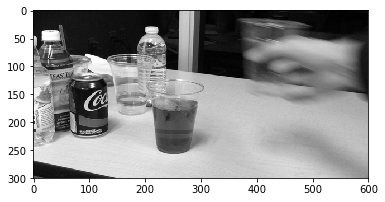

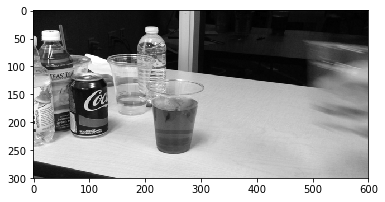

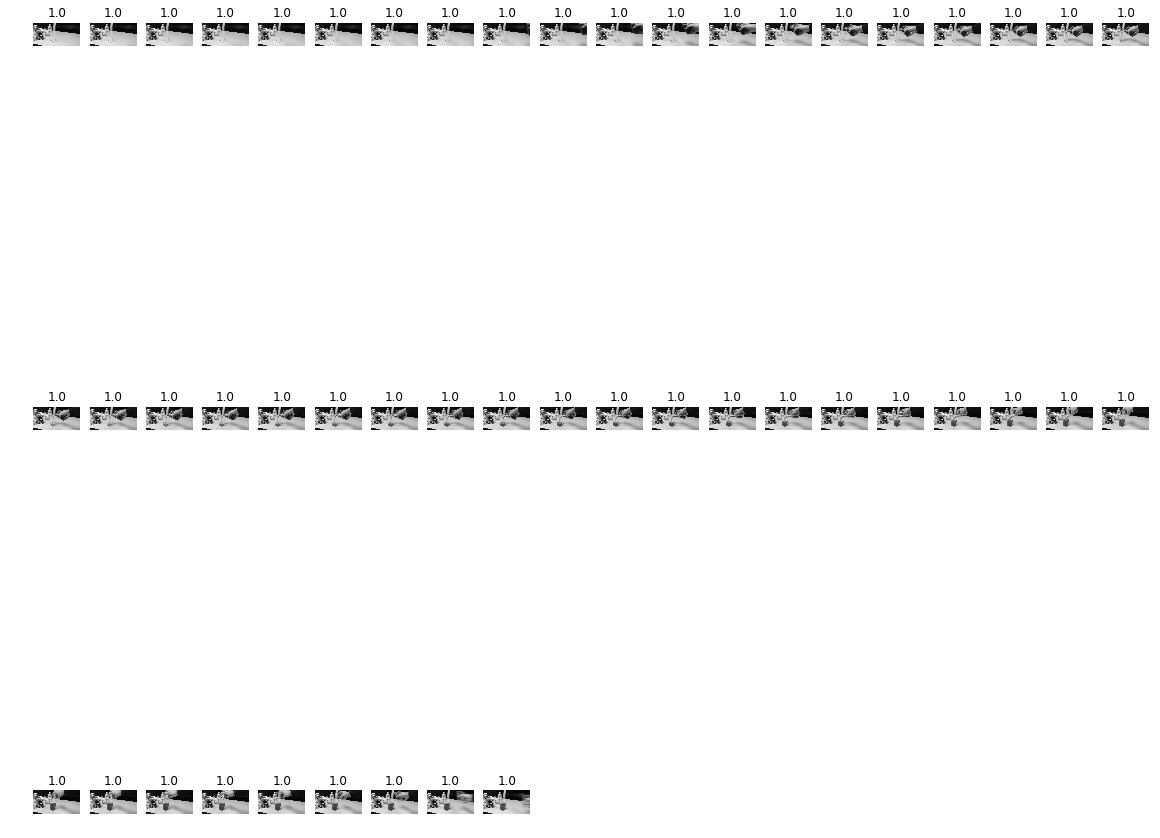

In [5]:
iteration=0
x=dset.batch_gen(0,2,batch_size,time_step,height,width,channel,imagefolderpath,gray=True)
print(x.shape)
for i in range (0,time_step):
    img=x[0][i]
    lsp.view_image(img)
    #plt.close()
img=x[0][1:50]  

y=np.ones([50])
lsp.view_images(img,y)

y=np.zeros([batch_size,nb_classes])

In [6]:
print(x.shape,y.shape)
x =x.reshape(x.shape[0],x.shape[1],height,width,channel)
print(x.shape,y.shape)
#print(x[0][1])

(2, 50, 300, 600) (2, 2)
(2, 50, 300, 600, 1) (2, 2)


#### Defining model

In [7]:
## Defining placeholders in tf
data = tf.placeholder(tf.float32, [None, time_step, height, width, channel]) #step_size=No: of frames in video sequence
target = tf.placeholder(tf.float32, [None, nb_classes])

In [8]:
## [1] Defining the model in keras using functional layers
input_ = Input(shape=(None, height, width, channel))
layer1=ConvLSTM2D(filters=1, kernel_size=(3, 3),padding='same', return_sequences=False)(input_)
model=Model(input_,layer1)
inter_out=model(data)
print(model.summary())

layer2=tf.nn.max_pool(inter_out,ksize=(1,2,2,1),strides=(1,2,2,1),padding='VALID')
layer3=tf.contrib.layers.flatten(layer2)
out=tf.layers.dense(layer3,nb_classes)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 300, 600, 1) 0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 300, 600, 1)       76        
Total params: 76
Trainable params: 76
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
predictions= tf.nn.softmax(out)
cross_entropy=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=target,logits=out))
optimizer = tf.train.AdamOptimizer(lr_rate)
minimize = optimizer.minimize(cross_entropy)
mistakes = tf.not_equal(tf.argmax(target, 1), tf.argmax(predictions, 1))
error = tf.reduce_mean(tf.cast(mistakes, tf.float32))

# Defining variables for writing summary
tf.summary.histogram("predictions",predictions )
tf.summary.scalar("cross_entropy",cross_entropy )
summary_op = tf.summary.merge_all()

#### Training model

In [10]:
#TODO : make data generater to generate class also
init_op = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init_op)

saver = tf.train.Saver()
train_writer = tf.summary.FileWriter('./logdir', sess.graph)

for i in range(epoch):
    ptr = 0
    for iteration in range(no_of_batches):
        x=dset.batch_gen(0+(batch_size*iteration),batch_size+(batch_size*iteration),batch_size,time_step,height,width,channel,imagefolderpath,gray=True)
        x =x.reshape(x.shape[0],x.shape[1],height,width,channel)
        y=np.zeros([batch_size,nb_classes])
        #print(x.shape,y.shape)
        
        summ_string,_=sess.run([summary_op,minimize],{data: x, target: y})
        train_writer.add_summary(summ_string,custom_global_step+1) # Writing summary to disc
        custom_global_step+=1
        print('Iteration {}'.format(iteration))
    print ('Epoch {}'.format(str(i)))

saver.save(sess, os.path.join(LOG_DIR, "model.ckpt"))

Iteration 0
Epoch 0
Iteration 0
Epoch 1
Iteration 0
Epoch 2
Iteration 0
Epoch 3
Iteration 0
Epoch 4


'./logdir/model.ckpt'

#### Visualising layers

(50, 300, 600, 1)
(1, 50, 300, 600, 1)
(1, 300, 600, 1)
(300, 600)


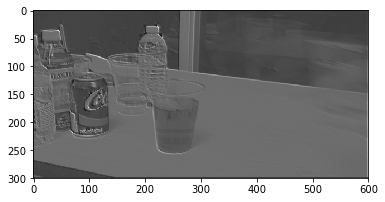

In [18]:
img=x[0]
print(img.shape)
img=img.reshape(1,img.shape[0],height,width,channel)
print(img.shape)
y_=np.zeros([1,nb_classes])
units = sess.run(inter_out,feed_dict={data:img, target:y_})
print(units.shape)
units=units.reshape(units.shape[1],units.shape[2])
print(units.shape)
plt.imshow(units)
plt.gray()
plt.savefig('./results/result2.png')
plt.show()

#### Tensorboard

In [ ]:
# Checking the items in the log directory
!tensorboard --inspect --logdir='./logdir/'

# Running tensorflow
print('If on windows system go to: http://localhost:6006')
!tensorboard --logdir='./logdir/'

In [ ]:
sess.close()